In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import pandas as pd
from random import seed
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec 
import gensim.downloader as api 
import ast
SEQUENCE_LENGTH = 10
seed(42) 

# Training the Language Model

Here we are going to be predicting the next word given a sequence of text. This is going to be solved using reccurant neural networks. Specifically using a LSTM

## Preprocessing

we are going to start first by preprocesing the data. Due to the way the the model is going to work. The data is going to collected into a list, meaning each line within the text will be stored in a list. The data is then going to be be converted into lower case (to help training). Additionally, all the digits would be removed

In [2]:

def get_data(filename="poirotInvestigates.txt"):
    """
        This function will simply open the file and read in the text. The text
        will be converted in to lower case characters. It then removes all characters
        which are digits.
    """
    lines = []
    with open(filename) as file:
        lines = [line for line in file if line != "\n"]
    
    for i in range(len(lines)):
        edit_line = lines[i].replace("\n", "")
        edit_line = edit_line.replace("***", " ")
        edit_line = edit_line.replace("_", "")
        edit_line = edit_line.replace('”', "")
        edit_line = edit_line.replace('“', "")
        lines[i] = edit_line.lower()
        
    return lines, pd.DataFrame(data={"lines" : lines})


In [3]:
lines, text = get_data()

To create a tokenizer to help encode the different words within the text

In [4]:
token = Tokenizer()
token.fit_on_texts(lines)
words_to_integer = token.word_index
vocab_length = len(words_to_integer) + 1

This is showing an example of a line within the list and the corresponding word sequence.

In [5]:
for line in lines:
        print(line)
        print(token.texts_to_sequences([line])[0])
        break

the project gutenberg ebook of poirot investigates, by agatha christie
[1, 79, 71, 500, 4, 15, 717, 38, 1201, 1202]


n_grams are going to be used to train the model. The input_sequence function creates the n grams for us, while the get_x_y function translates those input sequences to numerticals of x, y. To allow our neural network to process the data.

In [6]:
def input_sequences():
    # This is used to convered our list of text lines
    # into n_grams sequences 
    input_sequences = []
    maximum_seq_len = 0
    for line in lines:
        token_seq = token.texts_to_sequences([line])[0]
        for i in range(1, len(token_seq)): 
            n_gram_seqs = token_seq[:i+1]
            maximum_seq_len = max(maximum_seq_len, len(n_gram_seqs))
            input_sequences.append(n_gram_seqs)
    return input_sequences, maximum_seq_len

def get_x_y(input_sequences, maximum_seq_len):
    # This is for processing the input sequence into a format that neural network will understand
    # That is converting all the words into numbers
    # Then adding padding to ensure all the words are the same length
    input_sequences = pad_sequences(input_sequences, 
                        maxlen=maximum_seq_len, 
                        padding='pre') # To ensure all inputs are the same size, add leading 0's to beginning
    input_sequences = np.array(input_sequences)
    x_values = input_sequences[:,:-1] # we want the first n values from input_sequence to be x input
    y_labels = input_sequences[:, -1] # we want the last values from input sequence y outputs

    y_values = to_categorical(y_labels, num_classes=len(token.word_index) + 1 )

    return x_values, y_values, y_labels




In [7]:
input_seqs, maximum_seq_len = input_sequences()

The maximum sequence length is shown below

In [8]:
maximum_seq_len

17

In [9]:
x_values, y_values, y_labels = get_x_y(input_seqs, maximum_seq_len )

To further help with the training process, an embedding matrix is going to be used. The embedding matrix is used to capture the meaning of word. The type of embedding that is being used is called "word2vec"

In [10]:
def embedding_matrix():
    w2v = api.load("word2vec-google-news-300")
    vocab = w2v.vocab.keys()
    matrix = np.zeros((vocab_length, 300))
    for word, i in words_to_integer.items():
        if word in vocab:
            vector = w2v.get_vector(word)
            matrix[i] = vector
    return matrix



In [11]:
matrix = embedding_matrix()

## Model


In [12]:
def build_model():
    model = Sequential(
        [
            Embedding(input_dim = vocab_length, output_dim=300, weights=[matrix], input_length=maximum_seq_len-1, trainable=False),
            LSTM(256, input_shape=(64, vocab_length)),
            Dense(vocab_length, activation="softmax")
        ]
    )
    opti = RMSprop(0.01)
    model.compile(loss='categorical_crossentropy', optimizer=opti, metrics=['accuracy'])
    return model

In [13]:
model = build_model()

2022-02-24 20:19:50.164352: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 20:19:50.862679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7429 MB memory:  -> device: 0, name: Tesla M60, pci bus id: 0001:00:00.0, compute capability: 5.2


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 300)           2015700   
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 6719)              1726783   
                                                                 
Total params: 4,312,851
Trainable params: 2,297,151
Non-trainable params: 2,015,700
_________________________________________________________________


## Training


In [15]:
history = model.fit(x_values, y_values, 
    epochs=40, 
    workers=10, 
    use_multiprocessing=True,
    batch_size = 32)

Epoch 1/40
1578/1578 [==============================] - 21s 9ms/step - loss: 6.5126 - accuracy: 0.1041
Epoch 2/40
1578/1578 [==============================] - 14s 9ms/step - loss: 7.0522 - accuracy: 0.1160
Epoch 3/40
1578/1578 [==============================] - 14s 9ms/step - loss: 6.9691 - accuracy: 0.1168
Epoch 4/40
1578/1578 [==============================] - 14s 9ms/step - loss: 6.8286 - accuracy: 0.1241
Epoch 5/40
1578/1578 [==============================] - 14s 9ms/step - loss: 6.1726 - accuracy: 0.1491
Epoch 6/40
1578/1578 [==============================] 

2022-02-24 20:19:55.179670: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


In [16]:
model.save("h5-model-3.h5")

2022-02-24 20:29:08.808291: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:tensorflow:Assets written to: model-2/assets


INFO:tensorflow:Assets written to: model-2/assets


** shows the plot accuracy **


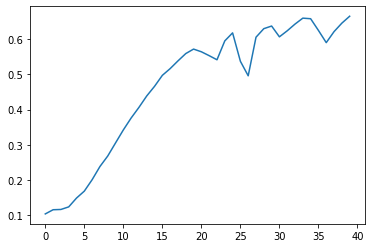

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])